In [6]:
%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import seqalign
import reveal
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
from intervaltree import IntervalTree

# Experiment 1 - Compare MUMmer and Reveal on Chromosome X (hg19/hg38)

How does a pairwise alignment of the human X chromosome (hg19 vs hg38) constructed by reveal compare to the same alignment produced by MUMmer.

Run mummer alignment of chrX hg38 vs hg19.

In [37]:
!time nucmer --prefix=nucmer.chrX.hg38.hg19 chrX.hg38.fa chrX.hg19.fa

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# S.length=156040896
# allcontigs 0
N=156040897
N/K=156040897
M.size()=4606672
# chrX_hg19
# P.length()=155270560
4: FINISHING DATA

real	41m54.242s
user	37m12.529s
sys	4m12.918s


In [ ]:
!dnadiff -d nucmer.chrX.hg38.hg19.delta

Run reveal alignment of chrX hg38 vs hg19.

In [248]:
!reveal align -o chrX.hg38.hg19 -r chrX.hg38.fa chrX.hg38.fa chrX.hg19.fa

07/08/2016 07:23:20 PM Constructing index...
07/08/2016 07:25:25 PM Done.
07/08/2016 07:25:25 PM Constructing pairwise-alignment...
07/08/2016 07:30:02 PM Done (96.88% identity, 150424330 bases out of 155270562 aligned).
07/08/2016 07:30:02 PM Merging nodes...
07/08/2016 07:30:02 PM Done.
07/08/2016 07:30:02 PM Writing graph...
07/08/2016 07:30:07 PM Done.
07/08/2016 07:30:07 PM Alignment graph written to: chrX.hg38.hg19.gfa


Detect bubbles in alignment graph.

In [249]:
!reveal bubbles chrX.hg38.hg19.gfa > chrX.hg38.hg19.bubbles

## Analysis of variants

All reveal bubbles (variants) are now stored in 'chrX.hg38.hg19.bubbles'.
All MUMmer/dnadiff variants are stored in the following files:

-   out.report  - Summary of alignments, differences and SNPs
-   out.delta   - Standard nucmer alignment output
-   out.1delta  - 1-to-1 alignment from delta-filter -1
-   out.mdelta  - M-to-M alignment from delta-filter -m
-   out.1coords - 1-to-1 coordinates from show-coords -THrcl .1delta
-   out.mcoords - M-to-M coordinates from show-coords -THrcl .mdelta
-   out.snps    - SNPs from show-snps -rlTHC .1delta
-   out.rdiff   - Classified ref breakpoints from show-diff -rH .mdelta
-   out.qdiff   - Classified qry breakpoints from show-diff -qH .mdelta
-   out.unref   - Unaligned reference sequence IDs and lengths
-   out.unqry   - Unaligned query sequence IDs and lengths

Get an overview of the total number of variants reported by MUMmer.

### SNP calls

As can be seen in the report generated by dnadiff, SNP calls by MUMmer are seperated into GSNPs and SNPs. Documentation states that GSNPs are SNPs that have at least 20bp flanking sequence, and SNPs have less than 20bp of flanking sequence. Most likely this is due to the fact that MUMmer uses Needleman-Wunsch alignment to close gaps between MUMs, probably SNPs in these regions are less reliable (in repetitive regions, homology/paralogy) and probably indicate multiple possible alignments producing different variant calls. 

#### Reveal

Inspect reveal bubbles for SNP calls.

In [13]:
rsnps=[]
bubbles=open("chrX.hg38.hg19.bubbles",'r')
for line in bubbles:
    cols=line.split("\t")
    a1,a2=cols[6].split(",")
    if len(a1)==1 and len(a2)==1 and a1!="-" and a2!="-":
        rsnps.append(line)
        continue

In [14]:
rsnppositions=[int(snp.split()[5]) for snp in rsnps]
print "Reveal detects",len(rsnppositions),"SNPs from the alignment graph."

Reveal detects 8831 SNPs from the alignment graph.


#### MUMmer

Load all SNP positions made by MUMmer by parsing the file out.snps.

In [15]:
msnppositions=[]
mgsnppositions=[]
for snpline in open("out.snps"):
    cols=snpline.split()
    if cols[1]!="." and cols[2]!=".":
        pos=int(cols[0])
        msnppositions.append(pos)
        if int(cols[4])>=20:
            mgsnppositions.append(pos)

In [16]:
print "MUMmer calls",len(msnppositions),"SNPs, from which",len(mgsnppositions),"are GSNPs"

MUMmer calls 9842 SNPs, from which 8028 are GSNPs


#### Compare called SNPs

Check the exact overlap between the three sets.

<IPython.core.display.Javascript object>


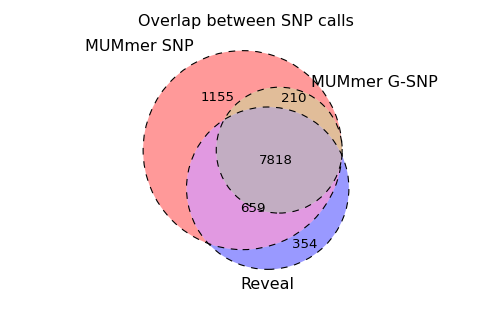

In [21]:
%matplotlib notebook
plt.figure(figsize=(6,4))
a=set(msnppositions)
b=set(mgsnppositions)
c=set(rsnppositions)
subsetcounts=(len(a-b-c), len(b-a-c), len((a&b)-c), len(c-a-b), len((a&c)-b), len((b&c)-a), 1000)
v = venn3(subsets=subsetcounts,set_labels = ('MUMmer SNP', 'MUMmer G-SNP', 'Reveal'))
venn3_circles(subsets=subsetcounts, linestyle='dashed', linewidth=1)
v.get_label_by_id('111').set_text(str(len(a&b&c)))
plt.title("Overlap between SNP calls")
plt.savefig("SNPovlp_nofilter.svg")
plt.show()

There are quite some calls that Mummer reports and Reveal does not. Probably a lot fall within 'hypervariable regions'. Let's make the same plot after filtering out the SNPs that fall within a hypervariable region. Add all hypervariable regions to an intervaltree and filter the two datasets.

In [22]:
vartree=IntervalTree()
rvariable=[]
rvariablelength=[]
bubbles=open("chrX.hg38.hg19.bubbles",'r')
for line in bubbles:
    cols=line.split("\t")
    a1,a2=cols[6].split(",")
    #and 'N' not in a1 and 'N' not in a2
    if a1!="-" and a2!="-" and (len(a1)>1 or len(a2)>1):
        refallele=cols[6].split(",")[int(cols[-1])]
        vartree[int(cols[5]):int(cols[5])+len(refallele)]=line
        rvariable.append(int(cols[5]))
        rvariablelength.append(len(refallele))

Now make the same plot for the filtered datasets.

<IPython.core.display.Javascript object>


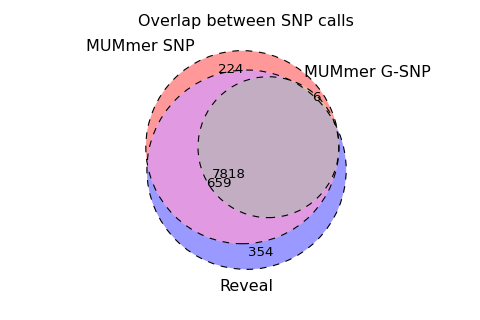

In [27]:
%matplotlib notebook
plt.figure(figsize=(6,4))
msnppositionsfiltered=set()
for snp in msnppositions:
    if len(vartree[snp])==0:
        msnppositionsfiltered.add(snp)
mgsnppositionsfiltered=set()
for snp in mgsnppositions:
    if len(vartree[snp])==0:
        mgsnppositionsfiltered.add(snp)
a=set(msnppositionsfiltered)
b=set(mgsnppositionsfiltered)
c=set(rsnppositions)
subsetcounts=(len(a-b-c), len(b-a-c), len((a&b)-c), len(c-a-b), len((a&c)-b), len((b&c)-a), 1000)
v = venn3(subsets=subsetcounts,set_labels = ('MUMmer SNP', 'MUMmer G-SNP', 'Reveal'))
venn3_circles(subsets=subsetcounts, linestyle='dashed', linewidth=1)
v.get_label_by_id('111').set_text(str(len(a&b&c)))
plt.title("Overlap between SNP calls")
plt.savefig("SNPovlp_filter.svg")
plt.show()

Ok, that changes a lot. At least now almost all GSNPs overlap in both callsets.

In [17]:
revealmissedgsnps=set(mgsnppositionsfiltered) - set(rsnppositions)
revealmissedsnps=set(msnppositionsfiltered) - set(rsnppositions) - set(mgsnppositionsfiltered)
mummermissedsnps=set(rsnppositions)-set(msnppositionsfiltered)
len(revealmissedgsnps),len(revealmissedsnps),len(mummermissedsnps)

(6, 224, 354)

#### Conclusion

After filtering SNP calls by the hypervariable regions reported by Reveal, all GSNP calls are also detected by reveal. Some SNPs are only reported by Reveal, some only by MUMmer. Visually explore later on what seems to be the reason for this.

### Indel calls

#### Reveal

Load indels called by Reveal.

In [18]:
rindels=[]
rindelsl=[]
rdeletes=[]
rdeletesl=[]
rinserts=[]
rinsertsl=[]
bubbles=open("chrX.hg38.hg19.bubbles",'r')
for line in bubbles:
    cols=line.rstrip().split("\t")
    pos=int(cols[5])
    refallele=cols[6].split(",")[int(cols[-1])]
    altallele=cols[6].split(",")[int(cols[-2])]
    if cols[6].find("N")!=-1 or cols[6].find("-")==-1:
        continue
    if refallele=='-':
        rinserts.append(pos)
        rinsertsl.append(len(altallele))
        rindelsl.append(len(altallele))
    else:
        rdeletes.append(pos)
        rdeletesl.append(len(refallele))
        rindelsl.append(len(refallele))
    rindels.append(pos)

In [19]:
print "Reveal calls",len(rindels),"indels"
print "Reveal calls",len(rinserts),"inserts"
print "Reveal calls",len(rdeletes),"deletes"

Reveal calls 2690 indels
Reveal calls 1309 inserts
Reveal calls 1381 deletes


#### MUMmer

Load all indels called by MUMmer.

In [20]:
rpos=set()
qpos=set()
mdeletes=[]
minserts=[]
mindels=[]
for snpline in open("out.snps"):
    cols=snpline.split()
    pos=int(cols[0])
    if cols[1]==".":
        if int(cols[0]) not in rpos:
            if len(vartree[int(cols[0])])==0:
                minserts.append(int(cols[0]))
            
        rpos.add(int(cols[0]))
    if cols[2]==".":
        if int(cols[3]) not in qpos:
            if len(vartree[int(cols[0])])==0:
                mdeletes.append(int(cols[0]))
            
        qpos.add(int(cols[3]))
    
mindels=minserts+mdeletes

print "MUMmer calls",len(mindels),"indels"
print "MUMmer calls",len(minserts),"inserts"
print "MUMmer calls",len(mdeletes),"deletes"

MUMmer calls 2645 indels
MUMmer calls 1298 inserts
MUMmer calls 1347 deletes


#### Compare called indels

Let's see how many indel calls overlap between the two callsets.

<IPython.core.display.Javascript object>


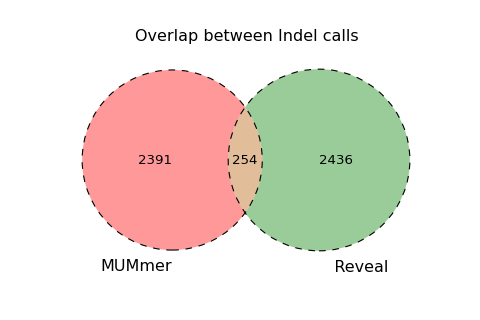

254

In [21]:
%matplotlib notebook
plt.figure(figsize=(6,4))
a=set(mindels)
b=set(rindels)
subsetcounts=(len(a-b), len(b-a), len(a&b))
v = venn2(subsets=subsetcounts,set_labels = ('MUMmer', '   Reveal'))
venn2_circles(subsets=subsetcounts, linestyle='dashed', linewidth=1)
plt.title("Overlap between Indel calls")
plt.show()
len(a&b)

Ai, very little overlap between the two sets. Further inspection shows that MUMmer always left-aligns indel calls, for that reason many calls off, add a 'wiggle' and check how much overlap there is then.

<IPython.core.display.Javascript object>


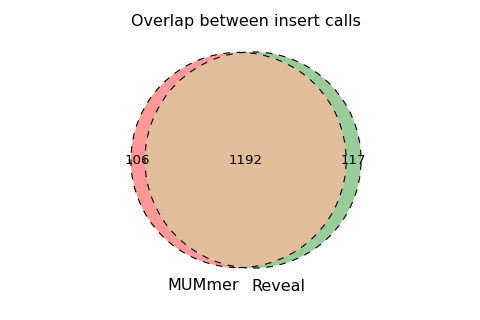

1172 1192


In [22]:
%matplotlib notebook
plt.figure(figsize=(6,4))
mindelsfiltered=set()
wiggle=25

rinserttree=IntervalTree()
for insert in rinserts:
    rinserttree[insert-wiggle:insert+1+wiggle]=insert

minserttree=IntervalTree()
for insert in minserts:
    minserttree[insert-wiggle:insert+1+wiggle]=insert

a=set(minserts)
b=set(rinserts)
revealmissedinserts=set()
mummermissedinserts=set()

ints=0
for start,end,call in rinserttree:
    if len(minserttree.search(start,end))!=0:
        ints+=1
    else:
        mummermissedinserts.add(call)

aints=0
for start,end,call in minserttree:
    if len(rinserttree.search(start,end))!=0 or len(vartree[call])!=0:
        aints+=1
    else:
        revealmissedinserts.add(call)

print ints,aints
        
subsetcounts=(len(a)-(aints), len(b)-(aints), aints)

v = venn2(subsets=subsetcounts,set_labels = ('MUMmer', 'Reveal'))
venn2_circles(subsets=subsetcounts, linestyle='dashed', linewidth=1)
plt.title("Overlap between insert calls")
plt.show()

<IPython.core.display.Javascript object>


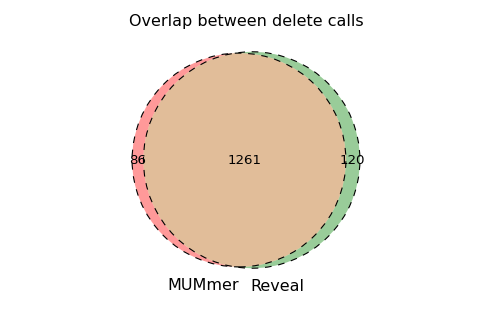

1240 1261


In [23]:
%matplotlib notebook
plt.figure(figsize=(6,4))
mindelsfiltered=set()
wiggle=25

rdeletetree=IntervalTree()
for delete in rdeletes:
    rdeletetree[delete-wiggle:delete+1+wiggle]=delete

mdeletetree=IntervalTree()
for delete in mdeletes:
    mdeletetree[delete-wiggle:delete+1+wiggle]=delete

a=set(mdeletes)
b=set(rdeletes)
revealmisseddeletes=set()
mummermisseddeletes=set()

ints=0
for start,end,call in rdeletetree:
    if len(mdeletetree.search(start,end))!=0:
        ints+=1
    else:
        mummermisseddeletes.add(call)

aints=0
for start,end,call in mdeletetree:
    if len(rdeletetree.search(start,end))!=0 or len(vartree[call])!=0:
        aints+=1
    else:
        revealmisseddeletes.add(call)

print ints,aints
        
subsetcounts=(len(a)-(aints), len(b)-(aints), aints)

v = venn2(subsets=subsetcounts,set_labels = ('MUMmer', 'Reveal'))
venn2_circles(subsets=subsetcounts, linestyle='dashed', linewidth=1)
plt.title("Overlap between delete calls")
plt.show()

<IPython.core.display.Javascript object>


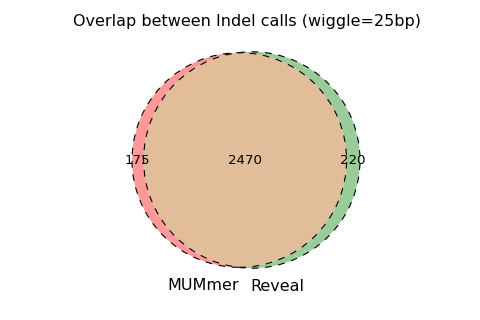

2428 2470


In [24]:
%matplotlib notebook
plt.figure(figsize=(6,4))
mindelsfiltered=set()
wiggle=25

rindeltree=IntervalTree()
for indel,l in zip(rindels,rindelsl):
    rindeltree[indel-wiggle:indel+1+wiggle]=indel

mindeltree=IntervalTree()
for indel in mindels:
    mindeltree[indel-wiggle:indel+1+wiggle]=indel

a=set(mindels)
b=set(rindels)
revealmissedindels=set()
mummermissedindels=set()

ints=0
for start,end,call in rindeltree:
    if len(mindeltree.search(start,end))!=0:
        ints+=1
    else:
        mummermissedindels.add(call)

aints=0
for start,end,call in mindeltree:
    if len(rindeltree.search(start,end))!=0 or len(vartree[call])!=0:
        aints+=1
    else:
        #if len(vartree[call])==0:
        revealmissedindels.add(call)

print ints,aints
        
subsetcounts=(len(a)-(aints), len(b)-(aints), aints)

v = venn2(subsets=subsetcounts,set_labels = ('MUMmer', 'Reveal'))
venn2_circles(subsets=subsetcounts, linestyle='dashed', linewidth=1)
plt.title("Overlap between Indel calls (wiggle=%sbp)"%wiggle)
plt.show()

In [25]:
len(revealmissedindels),len(mummermissedindels)

(175, 262)

### Inversion calls

#### Reveal

Inspect reveal bubbles for inverted sequence.

In [7]:
rinversions=[]
rinversionsl=[]
rinversionsscore=[]
bubbles=open("chrX.hg38.hg19.bubbles",'r')
for line in bubbles:
    cols=line.split("\t")
    a1,a2=cols[6].split(",")
    if len(a1)>100 and len(a2)>100 and "N" not in a1 and "N" not in a2 and abs(len(a1)-len(a2))<min([len(a1),len(a2)]):
        identrc=reveal.align_seq(reveal.rc(a1),a2)
        ident=reveal.align_seq(a1,a2)
        if identrc>ident:
            rinversions.append(int(line.split()[5]))
            rinversionsl.append(len(a1))
            rinversionsscore.append((identrc,ident))

#### MUMmer

Load the inversion breakpoints detected by MUMMer.

In [8]:
inv=!grep INV out.rdiff
minversions=[]
for i,line in enumerate(inv):
    if i%2==0:
        minversions.append(int(line.split()[2]))

#### Compare called inversions

How many inversions were detected by MUMmer, and how many by Reveal?

In [9]:
print "MUMmer calls",len(minversions),"inversions"
print "Reveal calls",len(rinversions),"inversions"

MUMmer calls 10 inversions
Reveal calls 12 inversions


Since inversion breakpoints tend to be quite variable depending heavily on alignment parameters, make some plots to see what the overlap is between the two sets.

<IPython.core.display.Javascript object>


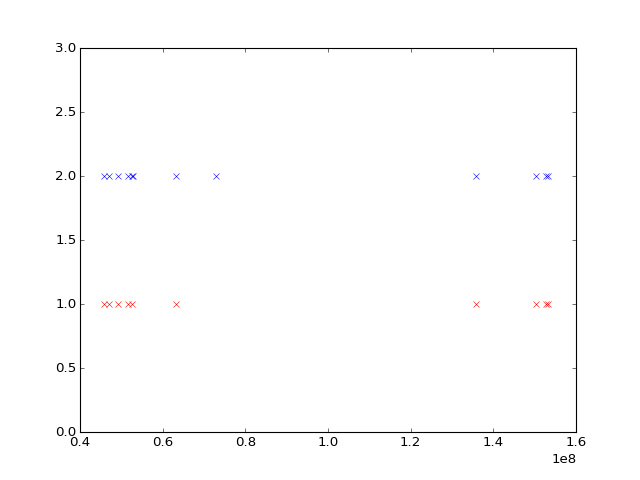

(0, 3)

In [29]:
%matplotlib notebook
plt.plot(minversions,[1]*len(minversions),'rx')
plt.plot(rinversions,[2]*len(rinversions),'bx')
plt.ylim(0,3)

<IPython.core.display.Javascript object>


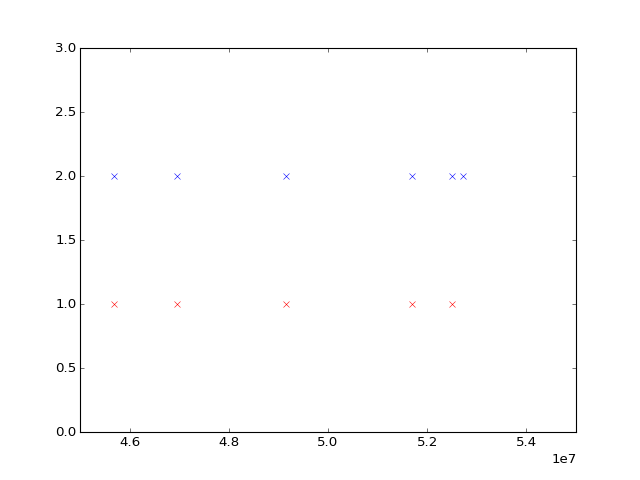

(45000000, 55000000)

In [30]:
%matplotlib notebook
plt.plot(minversions,[1]*len(minversions),'rx')
plt.plot(rinversions,[2]*len(rinversions),'bx')
plt.ylim(0,3)
plt.xlim(45000000,55000000) #zoom in a bit

From the above plots we can see that there are two distinct inversion calls in the Reveal set that are not in the callset of MUMmer. Lets make some dotplots of those regions to see if these are valid.

In [31]:
rinversions

[153149490,
 152729729,
 150403070,
 135723173,
 72860191,
 63185574,
 52729145,
 52502218,
 51692964,
 49157515,
 46951443,
 45689162]

In [32]:
inv

['chrX_hg38\tINV\t45689249\t45687803\t-1445',
 'chrX_hg38\tINV\t45692668\t45691227\t-1440',
 'chrX_hg38\tINV\t46951328\t46951331\t4',
 'chrX_hg38\tINV\t46971332\t46971112\t-219',
 'chrX_hg38\tINV\t49157515\t49155846\t-1668',
 'chrX_hg38\tINV\t49164375\t49162723\t-1651',
 'chrX_hg38\tINV\t51691984\t51668019\t-23964',
 'chrX_hg38\tINV\t51701558\t51701343\t-214',
 'chrX_hg38\tINV\t52502275\t52360116\t-142158',
 'chrX_hg38\tINV\t52539496\t52510823\t-28672',
 'chrX_hg38\tINV\t63185601\t63128999\t-56601',
 'chrX_hg38\tINV\t63249949\t63193343\t-56605',
 'chrX_hg38\tINV\t135808691\t135788258\t-20432',
 'chrX_hg38\tINV\t135851981\t135849312\t-2668',
 'chrX_hg38\tINV\t150403086\t150402164\t-921',
 'chrX_hg38\tINV\t150417930\t150417008\t-921',
 'chrX_hg38\tINV\t152729754\t152678580\t-51173',
 'chrX_hg38\tINV\t152789896\t152739664\t-50231',
 'chrX_hg38\tINV\t153126446\t153106016\t-20429',
 'chrX_hg38\tINV\t153273253\t153250226\t-23026']

Ok, so it's 52729145 and 72860191 that are not detected by MUMmer. Can we see anything from the size of the inversion events?

In [33]:
[rinv for rinv in zip(rinversions,rinversionsl,rinversionsscore)]

[(153149490, 100895, (0.9981562434948107, 0.2859507736838453)),
 (152729729, 9215, (0.9806916112141376, 0.31220682884258755)),
 (150403070, 14243, (0.9792837078651685, 0.32394662921348316)),
 (135723173, 73838, (0.8229637855846583, 0.5300387334434844)),
 (72860191, 417, (1.0, 0.16786570743405277)),
 (63185574, 7798, (0.992818671454219, 0.10271864580661708)),
 (52729145, 391, (0.8213058419243986, 0.21993127147766323)),
 (52502218, 8454, (1.0, 0.27584575348947243)),
 (51692964, 7400, (0.9995945945945945, 0.20864864864864865)),
 (49157515, 5209, (0.998848147437128, 0.11249760030716069)),
 (46951443, 19664, (0.9914056143205858, 0.14127339300244102)),
 (45689162, 2153, (1.0, 0.2977241058987459))]

It looks like MUMmer doesn't call the smaller inversions. Let's use mummerplot to make some targetted plots for the specific regions.

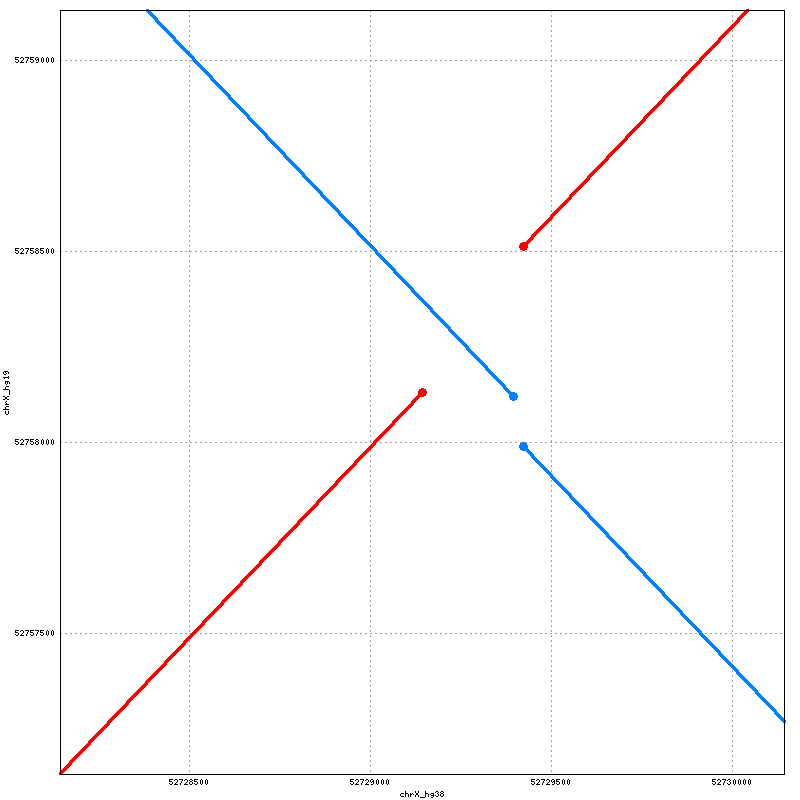

In [98]:
offset=1000
plotrange=(52729145,52758131-offset,52758131+offset,52729145-offset,52729145+offset)
os.system("mummerplot --png --prefix=%s  -y '[%s:%s]' -x '[%s:%s]' nucmer.chrX.hg38.hg19.delta"%plotrange)
Image(filename='52729145.png')

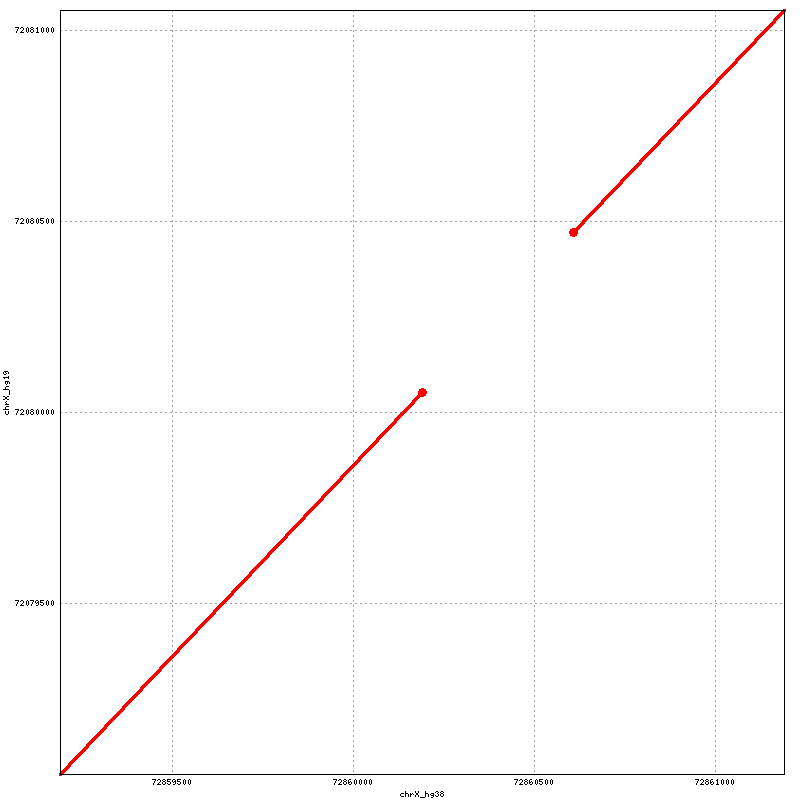

In [94]:
offset=1000
plotrange=(72860191 ,72080053-offset,72080053+offset,72860191 -offset,72860191 +offset)
os.system("mummerplot --png --prefix=%s  -y '[%s:%s]' -x '[%s:%s]' nucmer.chrX.hg38.hg19.delta"%plotrange)
Image(filename='72860191.png')

Ok, so in the first case (52729145) there does seem to be evidence for an inversion (at least, purely based on the sequence), also in the dotplot created by MUMmer itself. Most likely explanation is that this event is not recognised as such by MUMmer, due to either:
- the very long inverted repeat arms
- combination with the indel event at the flanking inverted repeat structure
- or merely the size of the event
- parameter settings of MUMmer

In the second case (72860191) the explanation is a bit harder since MUMmer does not detect the reverse complement MUM that spans the inverted stretch. Various reasons for this can be thought of, not the right parameter settings(?), a bug or (more interestingly) the fact that MUMmer does not have enough resolution in this area due to the repetitive nature of the region. Our recursive approach is apparently able to cope with this, since repetitive exact matches at the top level become unique at the local resolution(!).

To double check if 72860191 is actually an inversion, let's do a simple needleman-wunsch alignment of the unbridged stretch shown in the mum plot.

In [35]:
import seqalign
for name,seq1 in reveal.fasta_reader("chrX.hg38.fa"):
    s1=seq1[72860191:72860191+417]
    break
for name,seq2 in reveal.fasta_reader("chrX.hg19.fa"):
    s2=seq2[72080053:72080053+417]
    break

print seqalign.nw_align(s1,s2)
print seqalign.nw_align(reveal.rc(s1),s2)

('GTAGATGAAGCTGCACCTGCTGA--CTCAGT------------TTCCTGAGTGAGCAAATTTCA----------------TCACTAAGCTAACCAA--ACCTGCATGCC--TCCTCCCAGTAACAA--TG-----ATTGGAA----TGATGTCAACTTCTTCCATCAC-----AGGTCTATAATCTGTGATTGTCACCTTTT-----------------TTTGTCATATTAGCAGTTTTTGGTGACCGAAAAGCCCCAGTGAGATGAACCCGGTACCTCAGTTGGAAATGCAGA-AATCACCCATCTTCTGCGTCGCTCATGCTGGGAGCTGTAGACTGGAGCTGTTCCTATTCGGCCAT-----CTTGGAACCTCCCCCACTTTCATCCACGTCCATGTATTTCTTAGAAAGTCTCCACCAATCCCTAGAGATGTGCCTTCTGAGAAATACATGACTTTTAATG---AGTTTCACAGATCTAGTCAATGGTC', 'ACCATTGA--CTAGATCTG-TGAAACTCATTAAAAGTCATGTATTTCTCAGAAGGCACATCTCTAGGGATTGGTGGAGACTTTCTAAGAAATACATGGACGTGGATGAAAGTGGGGGAGGTTCCAAGATGGCCGAATAGGAACAGCTCCAGTCTACAGCTCCCAGCATGAGCGACGCAGAAGATGGGTGATT-TCTGCATTTCCAACTGAGGTACCGGGTTCATCTCACTGGGGCTTTTCGGTCACCAAAAACTGCTAATATGACAAA-----------------AAAAGGTGACAATCACAGATTATAGACCTG-----TGATGGAAGAAGTTGACATCA----TTCCAAT-----CATTGTTACTGGGAGGAGGC---------ATGCAGGTT--TGGTTAGCTTAGTGAT----------------GAAATTTGCTCACTCAGGAA-AC-TGAGTCAGCAGGTGCAGCTTCA----TCTA--CA------', -313)

When we reverse complement one of the alleles the alignment is almost perfect, so this does indeed seem to be a valid inversion!

#### Conclusion

Reveal seems to be more sensitive to detect inversions, **mostly the smaller inversions (<1000bp) that are flanked by very large inverted repeat structures seem to be missed by MUMmer.**

# Explore all variant calls in one plot

In order to figure out what happens in the cases where MUMmer and Reveal do not agree, let's make a plot that intergrates all the aforementioned missed variants along the x-axis of the chromosome.

<IPython.core.display.Javascript object>


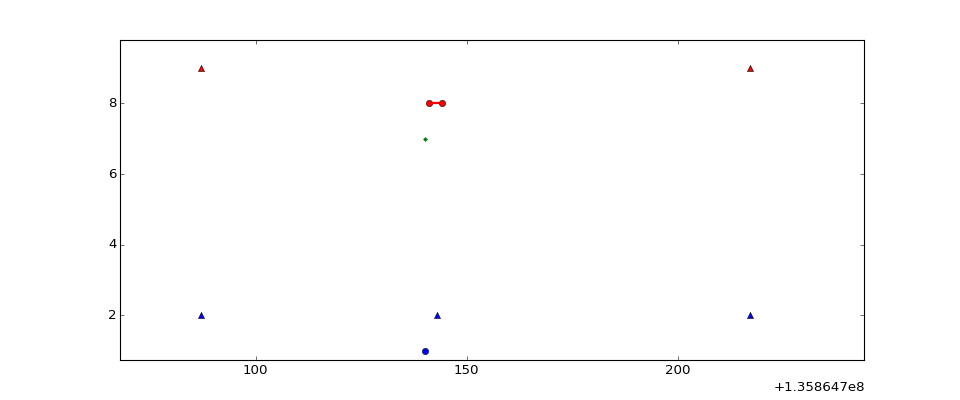

In [33]:
%matplotlib notebook
plt.figure(figsize=(12,5))
#plt.title("test")
#plt.plot(minserts,[0]*len(minserts),'bx')
#plt.plot(mdeletes,[1]*len(mdeletes),'bo')
plt.plot(mindels,[1]*len(mindels),'bo')
plt.plot(msnppositions,[2]*len(msnppositions),'b^')
plt.plot(sorted(list(mummermissedsnps)),[3]*len(mummermissedsnps),'k^')
plt.plot(sorted(list(mummermissedinserts)),[4]*len(mummermissedinserts),'kx')
plt.plot(sorted(list(mummermisseddeletes)),[4]*len(mummermisseddeletes),'k.')
plt.plot(sorted(list(revealmissedsnps)),[5]*len(revealmissedsnps),'g^')
plt.plot(sorted(list(revealmissedgsnps)),[6]*len(revealmissedgsnps),'g*')

#plt.plot(sorted(list(revealmissedindels)),[7]*len(revealmissedindels),'gx')
plt.plot(sorted(list(revealmissedinserts)),[7]*len(revealmissedinserts),'gx')
plt.plot(sorted(list(revealmisseddeletes)),[7]*len(revealmisseddeletes),'g.')


for v,l in zip(rvariable,rvariablelength):
    if v in rinversions:
        plt.plot(v,8,'ko')
        plt.plot([v,v+l],[8,8],'b-',linewidth=3)
        plt.plot(v+l,8,'ko')
    else:
        plt.plot(v,8,'ro')
        plt.plot([v,v+l],[8,8],'r-',linewidth=2)
        plt.plot(v+l,8,'ro')
plt.plot(rsnppositions,[9]*len(rsnppositions),'r^') #snps are ^
plt.plot(rindels,[10]*len(rindels),'ro') #deletes are o
#plt.plot(rdeletes,[10]*len(rdeletes),'ro') #deletes are o
#plt.plot(rinserts,[11]*len(rinserts),'rx') #inserts are x
plt.ylim(0,11)
plt.show()

Missed indel and SNP calls can be attributed to:
- MUMmer left aligns tandem repeat induced indels (e.g. delete at 53909471 (reveal), vs 53909495), Reveal determines the position of the call depending on which MUM got aligned first
- Ambiguous alignments of low compexity regions (AT train VTR 53907700:53910000)
- Ambiguous alignments of low compexity regions (115402972:115404413)
- Indel calls instead of SNP calls 116514000
- Flanking regions of inversions: 135628000 - 135942000

<IPython.core.display.Javascript object>


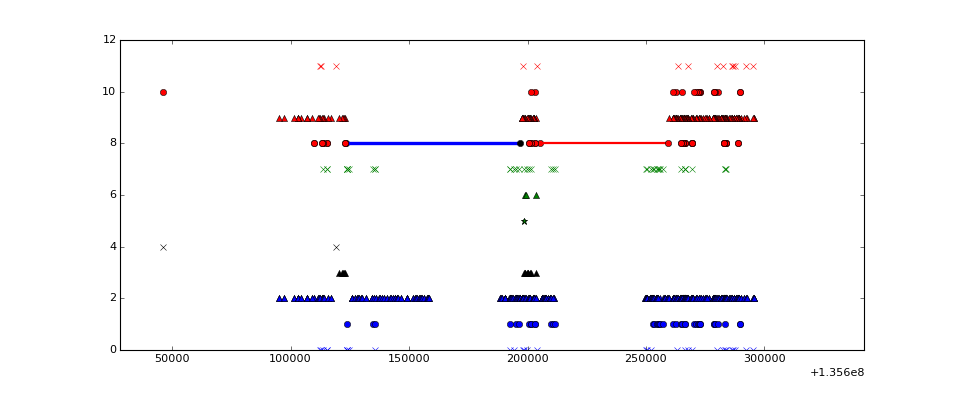

(135628000, 135942000)

In [33]:
%matplotlib notebook
plt.figure(figsize=(12,5))
plt.plot(minserts,[0]*len(minserts),'bx')
plt.plot(mdeletes,[1]*len(mdeletes),'bo')
plt.plot(msnppositions,[2]*len(msnppositions),'b^')
plt.plot(mgsnppositions,[2]*len(mgsnppositions),'b^')

plt.plot(sorted(list(mummermissedsnps)),[3]*len(mummermissedsnps),'k^')
plt.plot(sorted(list(mummermissedindels)),[4]*len(mummermissedindels),'kx')

plt.plot(sorted(list(revealmissedsnps)),[5]*len(revealmissedsnps),'g*')
plt.plot(sorted(list(revealmissedgsnps)),[6]*len(revealmissedgsnps),'g^')
plt.plot(sorted(list(revealmissedindels)),[7]*len(revealmissedindels),'gx')
for v,l in zip(rvariable,rvariablelength):
    if v in rinversions:
        plt.plot(v,8,'ko')
        plt.plot([v,v+l],[8,8],'b-',linewidth=3)
        plt.plot(v+l,8,'ko')
    else:
        plt.plot(v,8,'ro')
        plt.plot([v,v+l],[8,8],'r-',linewidth=2)
        plt.plot(v+l,8,'ro')
plt.plot(rsnppositions,[9]*len(rsnppositions),'r^') #snps are ^
plt.plot(rdeletes,[10]*len(rdeletes),'ro') #deletes are o
plt.plot(rinserts,[11]*len(rinserts),'rx') #inserts are x
plt.xlim(135628000,135942000)

In [61]:
len(revealmissedindels)

382